# Advanced Lane Finding Project
---
The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Camera calibration

In [1]:
%%HTML
<style> code {background-color : pink !important;} </style>

### Extract `object points` and `image points` for camera calibration

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib inline
# %matplotlib qt

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

## Pipeline test on test image

### Undistort image

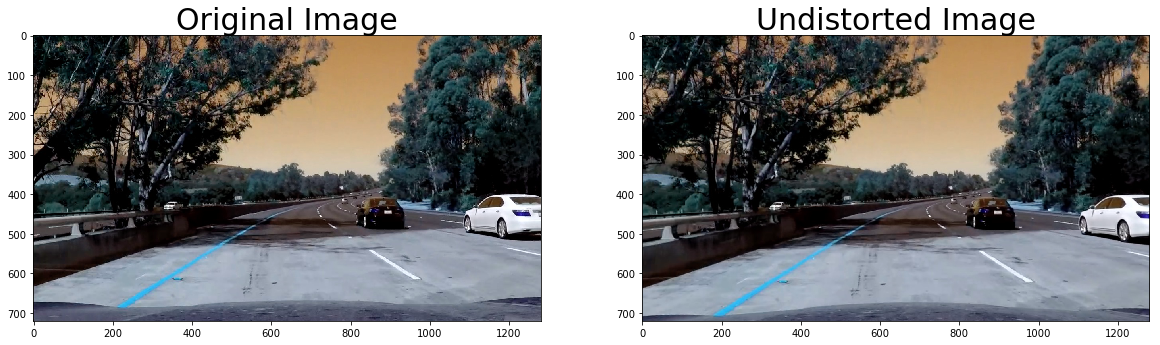

In [31]:
# Test undistortion on an image
# img = cv2.imread('./test_images/straight_lines2.jpg')
img = cv2.imread('./test_images/test5.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size ,None,None)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "./camera_cal/cam_cal_pickle.p", "wb" ) )


def undistort(img):
    '''
    undisort input image using camera calibration data
    '''
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    return undist_img

undist_img = undistort(img)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist_img)
ax2.set_title('Undistorted Image', fontsize=30)

### Gradient Transform on Full Image

 _Note : Gradient transform detects lane line very well but there are also a lot of unncessary data. 
To remove these unncessary data, I used gradient transform on Cropped Image and gradient transform on full image combined. This will be showed following cells._

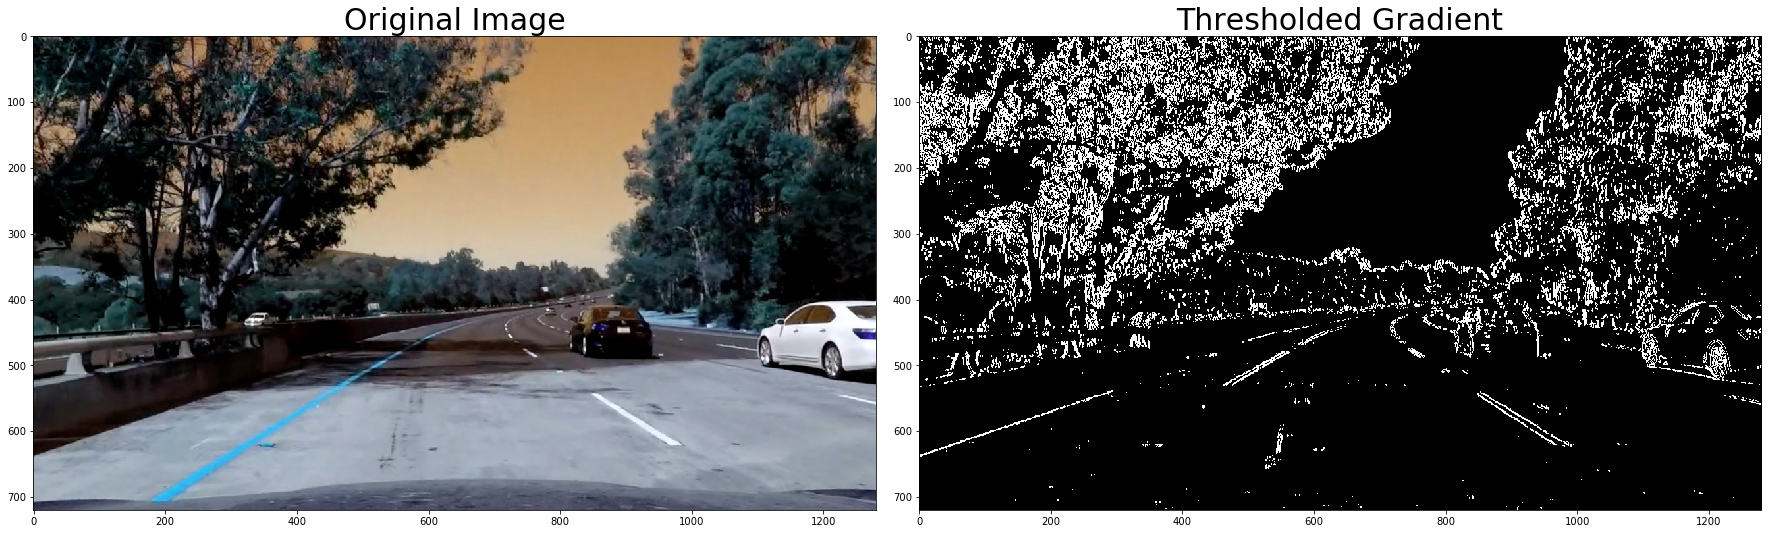

In [32]:
def abs_sobel_thresh(img, orient='x',sobel_kernel= 9, thresh=(0,255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

image = undist_img
# # Test Run the function , with orient orient='y'
# blured_image =  gaussian_blur(image, kernel_size= 9)
grad_binary_full = abs_sobel_thresh(image, orient='x',sobel_kernel= 9, thresh=(15,80))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(grad_binary_full, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Cropping Image in Interested Region
_This method can be applied generally if we can measure the slop of road using sensors.(i.g. Gyro or gravity sensor are already in your smart phone)_

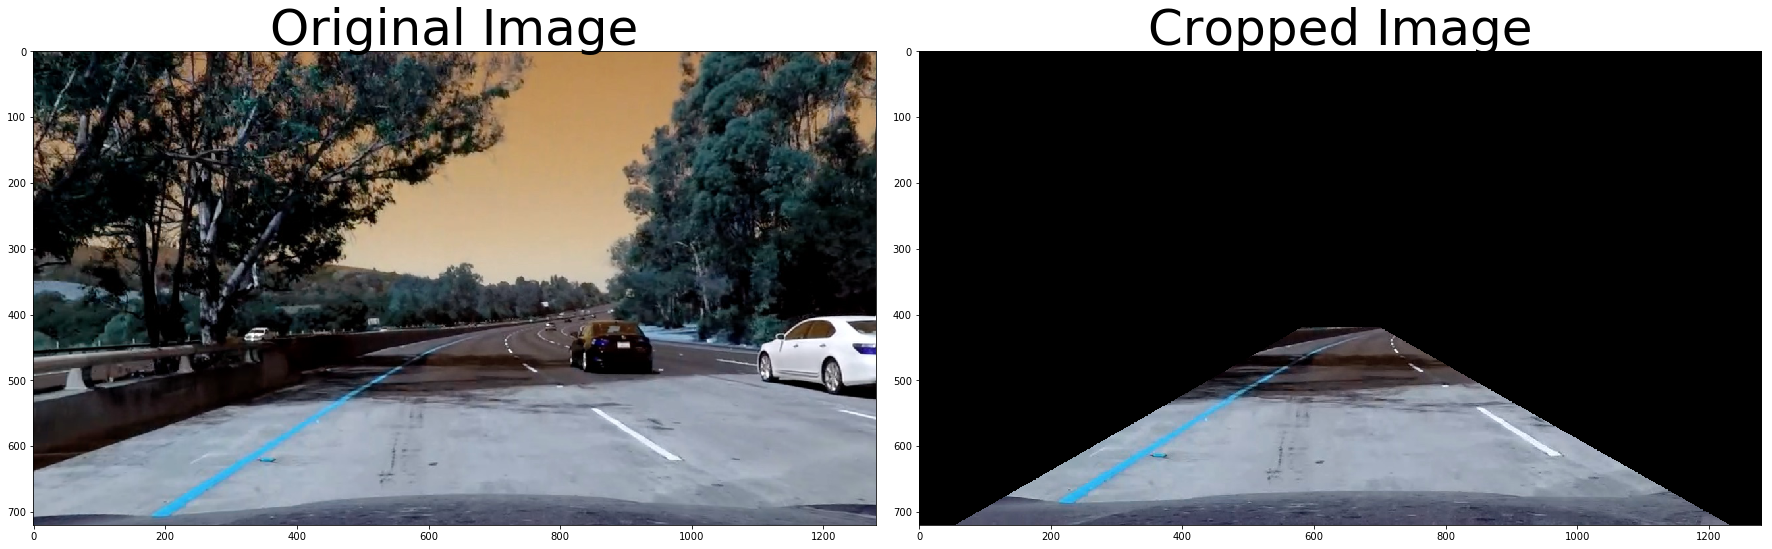

In [33]:
## defining a four sided polygon to mask
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

## Test function
imshape = image.shape
max_x = imshape[1]
max_y = imshape[0]
center_x = imshape[1]/2
center_y = imshape[0]/2
vertices = np.array([[(55,imshape[0]),
                     (imshape[1]/2-60, imshape[0]/2+60), 
                     (imshape[1]/2+60, imshape[0]/2+60), 
                     (imshape[1]-50,imshape[0])]], dtype=np.int32)
cropped_img = region_of_interest(img, vertices)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(cropped_img)
ax2.set_title('Cropped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### HLS Transform and Extract Thresholed S-Channel
_I applied max-min normalization on S-Channel. This will make treshold value more robust against various images._

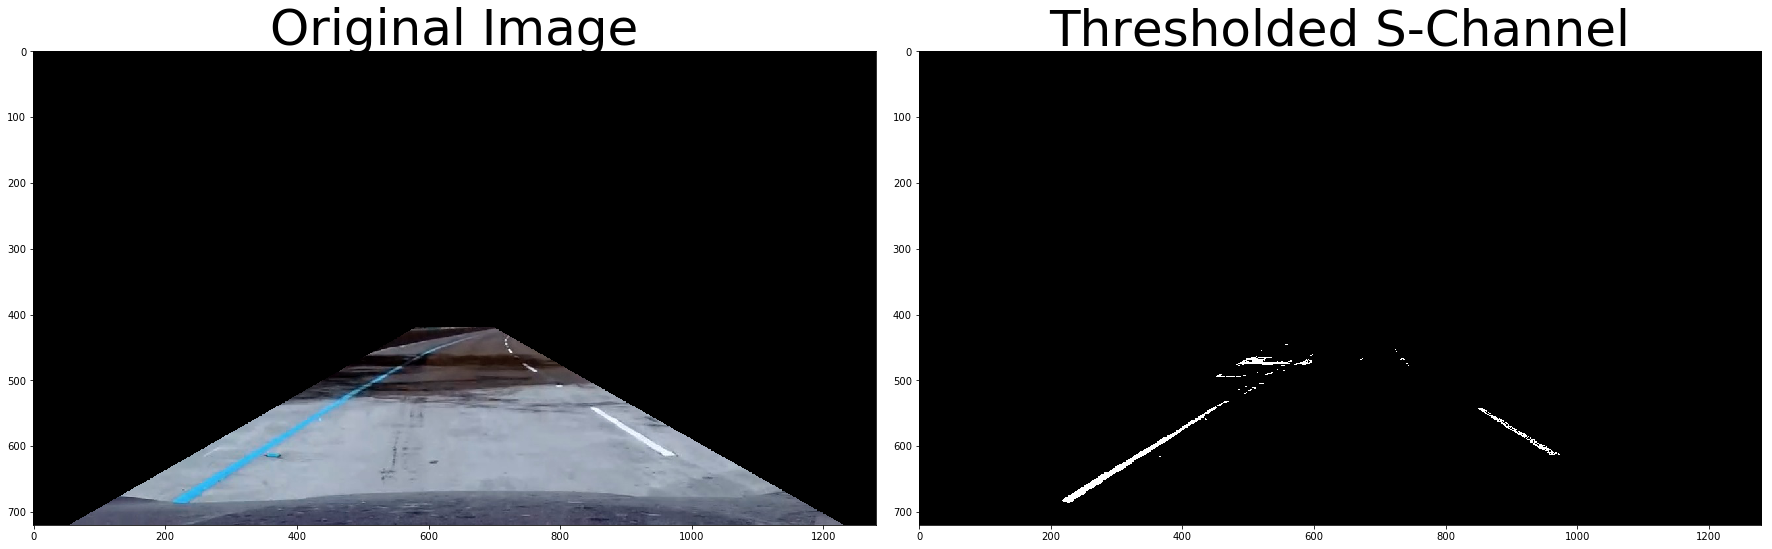

In [34]:
image = cropped_img
# Define a function that thresholds the S-channel of HLS
def hls_select(img, channel = 'S' , thresh=(-1,1)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if channel == 'H':
        out_channel = hls[:,:,0]
    elif channel == 'L':
        out_channel = hls[:,:,1]
    else :
        out_channel = hls[:,:,2]
    
    ## max-min normaliztion
    normalized = (out_channel-np.min(out_channel))/(np.max(out_channel) - np.min(out_channel))
    
    binary_output = np.zeros_like(out_channel)
    binary_output[(normalized > thresh[0]) & (normalized <= thresh[1])] = 1
    return binary_output

# s_binary = hls_select(image,channel = 'S', thresh=(210/255.0-0.5, 255/255.0-0.5))
s_binary = hls_select(image,channel = 'S', thresh=(180/255, 255/255.0))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(s_binary, cmap='gray')
ax2.set_title('Thresholded S-Channel', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Gradient on Cropped Image
_Owing to cropping, there is much of good lane data but your can see two noisy straight line in the left and right. This noise will be removed in the following cell._

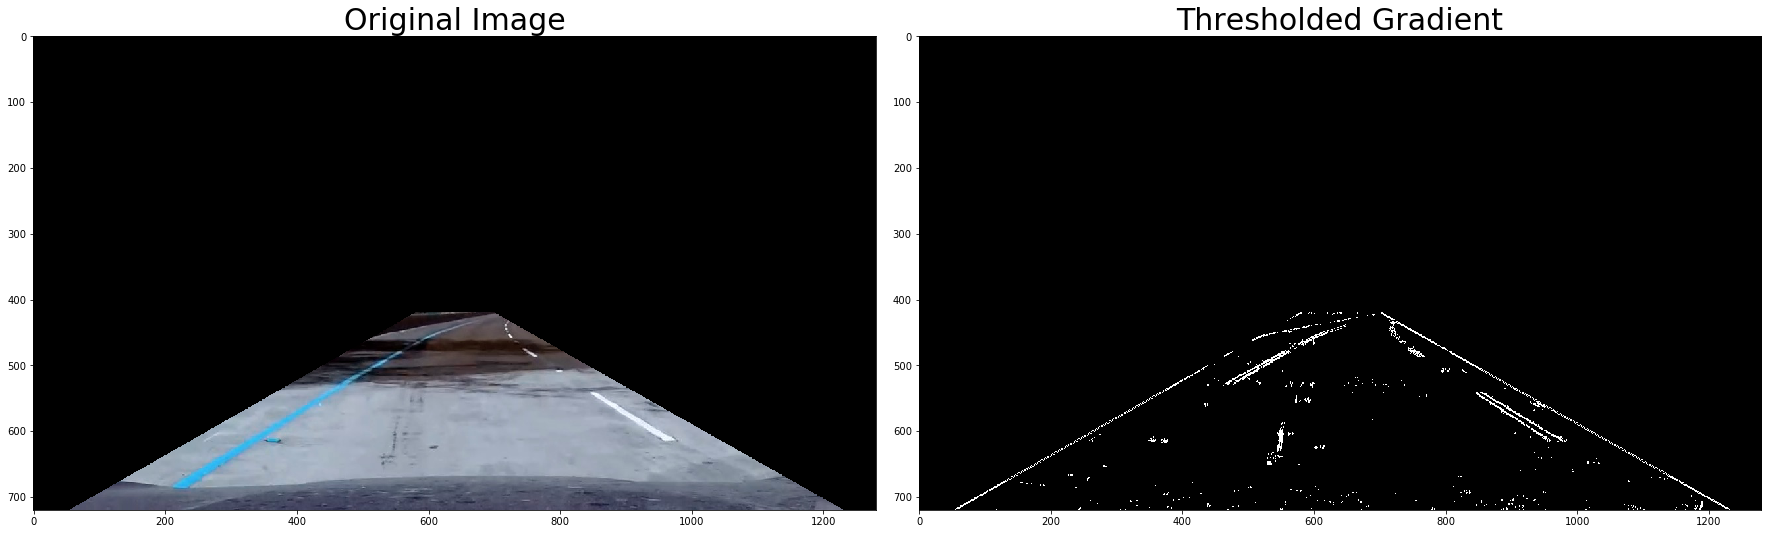

In [35]:
# # Test Run the function , with orient orient='y'
# blured_image =  gaussian_blur(image, kernel_size= 9)
grad_binary_cropped = abs_sobel_thresh(image, orient='x',sobel_kernel= 9, thresh=(20,120))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(grad_binary_cropped, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Combining Full & Cropped Gradient
_Two noisy straight line in the left and right are removed._

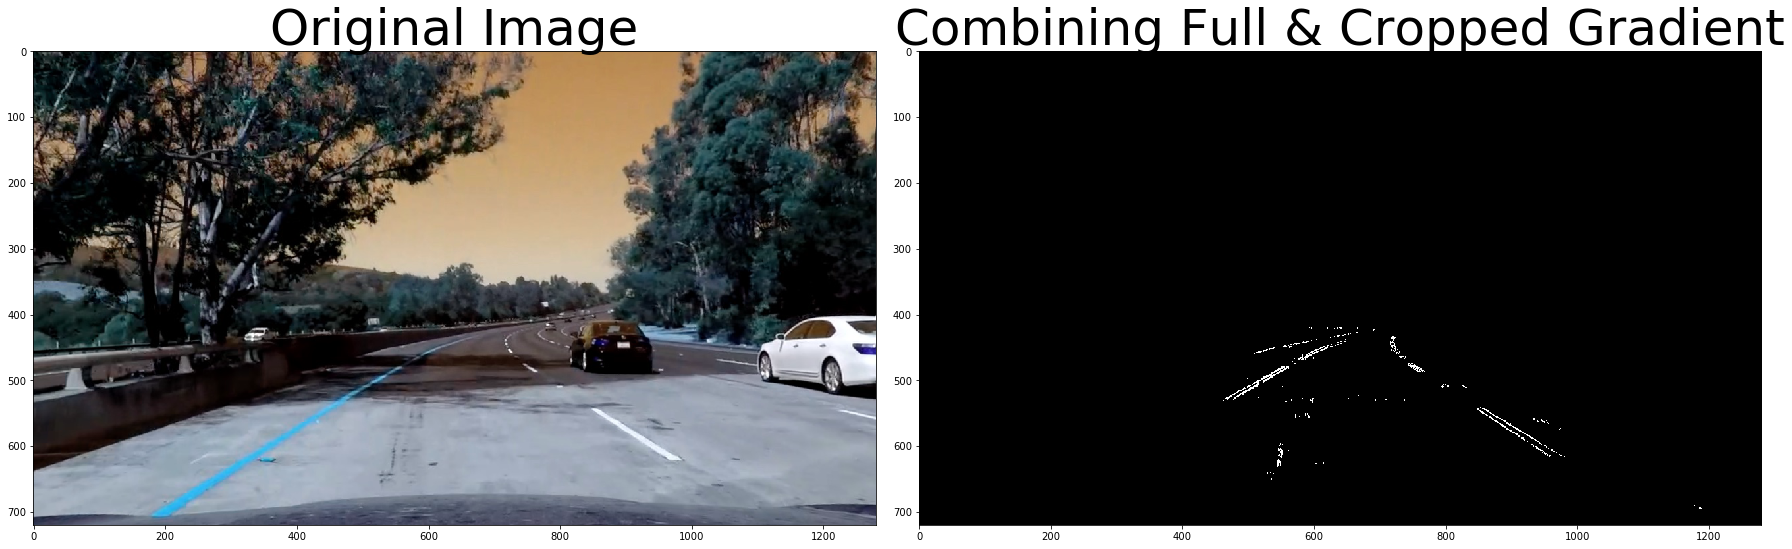

In [36]:
combined = np.zeros_like(grad_binary_full)
combined[((grad_binary_cropped == 1) & (grad_binary_full == 1))] = 1

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combining Full & Cropped Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Combining Full & Cropped Gradient & S-Channel
_Add S-Channel information. I am able to extract good lane line data _

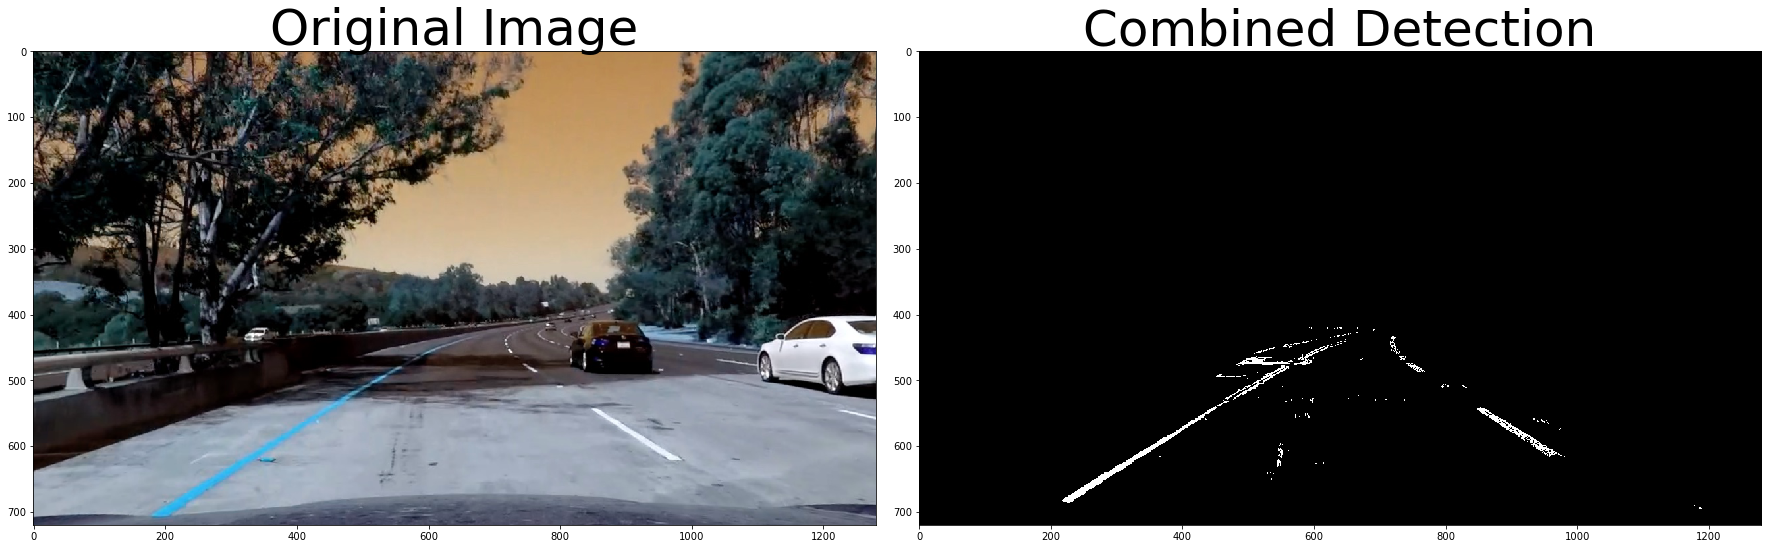

In [37]:
combined = np.zeros_like(s_binary)
combined[(s_binary==1) | ((grad_binary_cropped == 1) & (grad_binary_full == 1))] = 1

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combined Detection', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Implement binary lane image extraction
_Implement function extracting lane line from image as show above process._

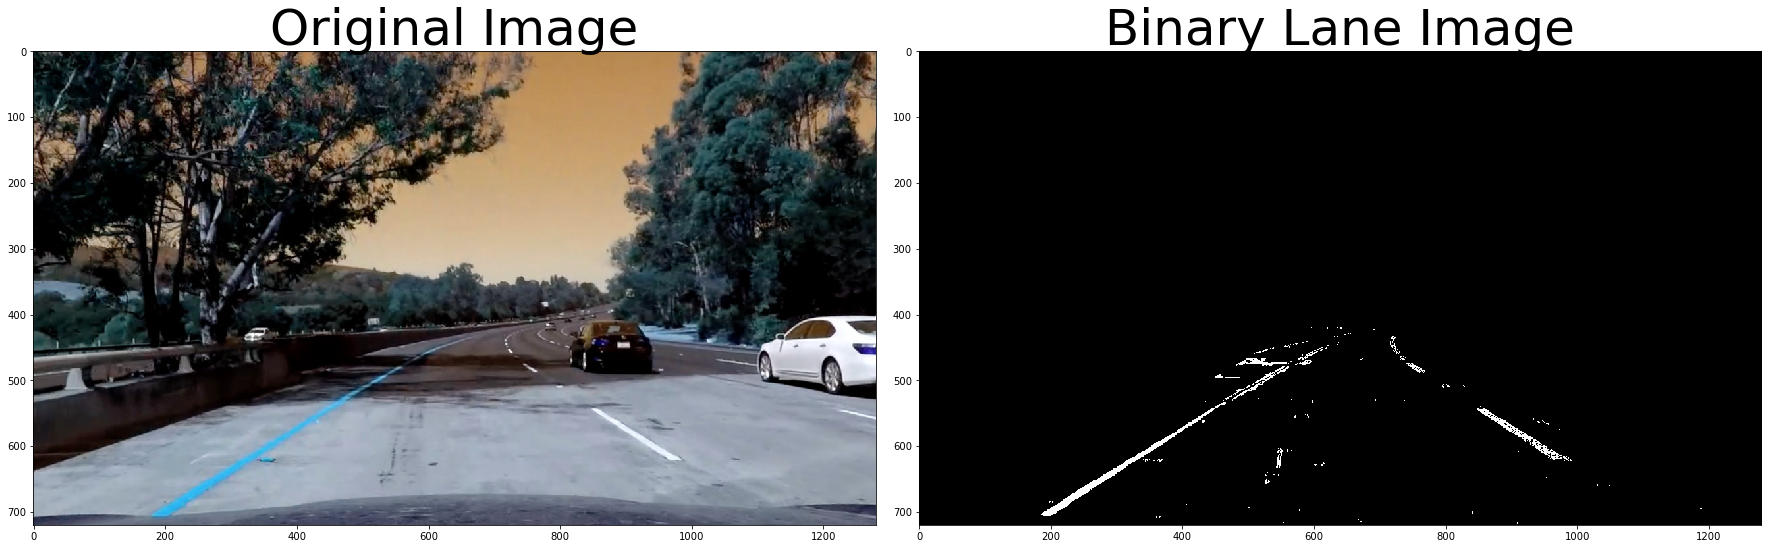

In [38]:
def find_lane_binary(image) :
    '''
    extract bynary lane image    
    '''
    
    ## get thresholded gradient
    grad_binary_full = abs_sobel_thresh(image, orient='x',sobel_kernel= 9, thresh=(20,120))
    
    ## Cropping Image
    imshape = image.shape
    max_x = imshape[1]
    max_y = imshape[0]
    center_x = imshape[1]/2
    center_y = imshape[0]/2
    vertices = np.array([[(55,imshape[0]),
                         (imshape[1]/2-60, imshape[0]/2+60), 
                         (imshape[1]/2+60, imshape[0]/2+60), 
                         (imshape[1]-50,imshape[0])]], dtype=np.int32)
    cropped_img = region_of_interest(image, vertices)
    
    ## HLS Transform and Extract Thresholed S-Channel
    s_binary = hls_select(cropped_img,channel = 'S', thresh=(180/255, 255/255.0))
    
    ## Gradient on Cropped Image
    grad_binary_cropped = abs_sobel_thresh(cropped_img, orient='x',sobel_kernel= 9, thresh=(20,120))
    
    ## Combination
    combined = np.zeros_like(s_binary)
    combined[(s_binary==1) | ((grad_binary_cropped == 1) & (grad_binary_full == 1))] = 1
    
    return combined

combined = find_lane_binary(undist_img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Binary Lane Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Apply a perspective transform to rectify binary image ("birds-eye view")

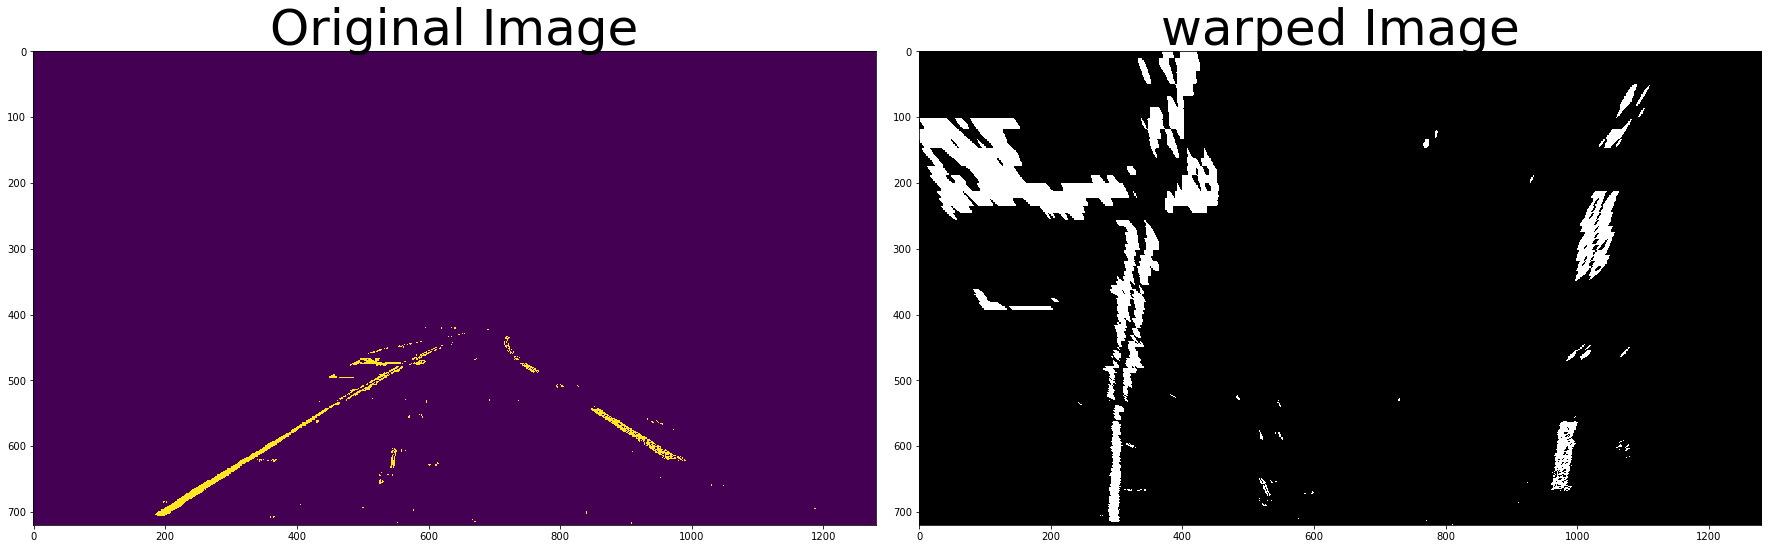

In [39]:
def perspective_transform(binary_image , warp_unwarp ='warp'):
    
    image_shape = binary_image.shape
    img_size = (image_shape[1], image_shape[0])
#     src = np.float32([ [585,460],[203,720],[1127,720],[ 695, 460] ])
#     dst = np.float32([ [320, 0],[320, 720],[960, 720],[ 960, 0] ])
    src = np.float32([ [585,460],[203,720],[1127,720],[ 695, 460] ])
    dst = np.float32([ [350, 0],[320, 720],[960, 720],[ 930, 0] ])

    warp_M = cv2.getPerspectiveTransform(src, dst)
    warp_Minv = cv2.getPerspectiveTransform(dst, src)

    # Warp or unwarpthe image using OpenCV warpPerspective()
    if warp_unwarp == 'warp':
        warped = cv2.warpPerspective(binary_image, warp_M, img_size)
    elif warp_unwarp == 'unwarp':
        warped = cv2.warpPerspective(binary_image, warp_Minv, img_size)
    else:
        print('Specifiy warp or unwarp')
        
    return warped
    
warped = perspective_transform(combined , warp_unwarp ='warp')
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(combined)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped, cmap='gray')
ax2.set_title('warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Fit Lane Line With Polynomial using Sliding Windows

### Find sliding window starting point using histogram

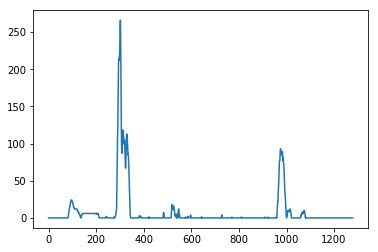

In [40]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
binary_warped = warped
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

### Fit left , right lane line using sliding windows

left , right line should be parallel.
using this fact , copy left line -> right line and vice versa.
by doing this, you can average the information of left&right line
robut in normal case and extremely effective when a line don't have enough data to fit in.

In [41]:
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint
distance_left_right = np.int32(rightx_base - leftx_base)

# Choose the number of sliding windows
nwindows = 9

# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)

# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base

# Set the width of the windows +/- margin
margin = 50

# Set minimum number of pixels found to recenter window
minpix = 50

# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

leftx,lefty,rightx,righty = [] , [], [], []
# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
    
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# ## left , right line should be parallel.
# ## using this fact , copy left line -> right line and vice versa.
# ## by doing this, you can average the information of left&right line
# ## robut in normal case and extremely effective when a line don't have enough data to fit in.
# rightx_2_leftx =  rightx - distance_left_right
# leftx_2_rightx =  leftx  + distance_left_right
# leftx = np.concatenate((leftx , rightx_2_leftx))
# rightx = np.concatenate((rightx , leftx_2_rightx))

# righty_2_lefty = righty
# lefty_2_righty = lefty
# lefty = np.concatenate((lefty , righty_2_lefty))
# righty = np.concatenate((righty , lefty_2_righty))


# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

### Plot fitting result

You can see there are not enough data in left line top region to predict poynomial.
But right line have good data in top region. So I copied and shifted them to left region and used for 
left line fitting.

(720, 0)

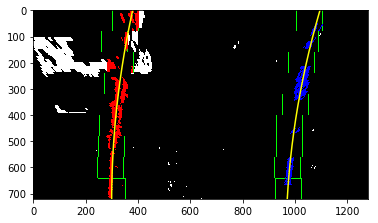

In [42]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)

plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### Visualization

(720, 0)

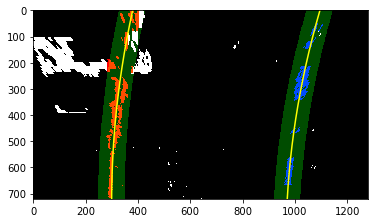

In [43]:
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))

right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### Calculate curvature and distance from lane center

In [44]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
left_fit = left_fitx
right_fit =  right_fitx

y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
leftx = left_fitx
rightx = right_fitx
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)

# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
curvature_text_on_img = "Radius of curvature: %.2f m" % right_curverad

# Now our radius of curvature is in meters
print('curvature = {}'.format(right_curverad) + 'm')

# distance from the lane center
lane_center = (right_fitx[719] + left_fitx[719])/2
center_offset_pixels = abs(imshape[1]/2 - lane_center)
distance_from_center = xm_per_pix*center_offset_pixels
distance_from_center_text_on_imag = "Distance from the lane center: %.2f m" % distance_from_center
print('Distance from the lane center = {}'.format(distance_from_center) + 'm')

2.14658078891e+14 1.78839456356e+15
curvature = 1007.5464580820328m
Distance from the lane center = 0.02538846583216553m


### Unwarp result and overlap to the original image

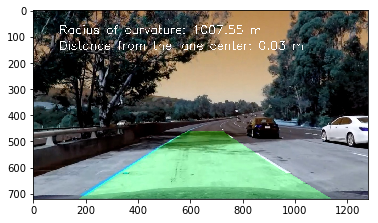

In [45]:
# Create an image to draw the lines on
warp = result
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = perspective_transform(color_warp,warp_unwarp = 'unwarp')

# Combine the result with the original image
overlayed_result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
cv2.putText(overlayed_result,curvature_text_on_img , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
cv2.putText(overlayed_result, distance_from_center_text_on_imag, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)

plt.imshow(overlayed_result)

## Final Pipeline Implementation
---

In [46]:
def brutal_search(binary_warped) :
    '''
    Searching lane line using histogram and sliding windows
    Use if there is no previous fit data
    '''
    
    ### Find starting point using histogram
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    distance_left_right = np.int32(rightx_base - leftx_base)

    # Choose the number of sliding windows
    nwindows = 9

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set the width of the windows +/- margin
    margin = 50

    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    leftx,lefty,rightx,righty = [] , [], [], []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    return left_lane_inds , right_lane_inds

In [47]:
def fast_search(binary_warped,left_fit,right_fit) :
    '''
    Search lane line using previous fit data
    '''
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    margin = 100
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    return left_lane_inds, right_lane_inds

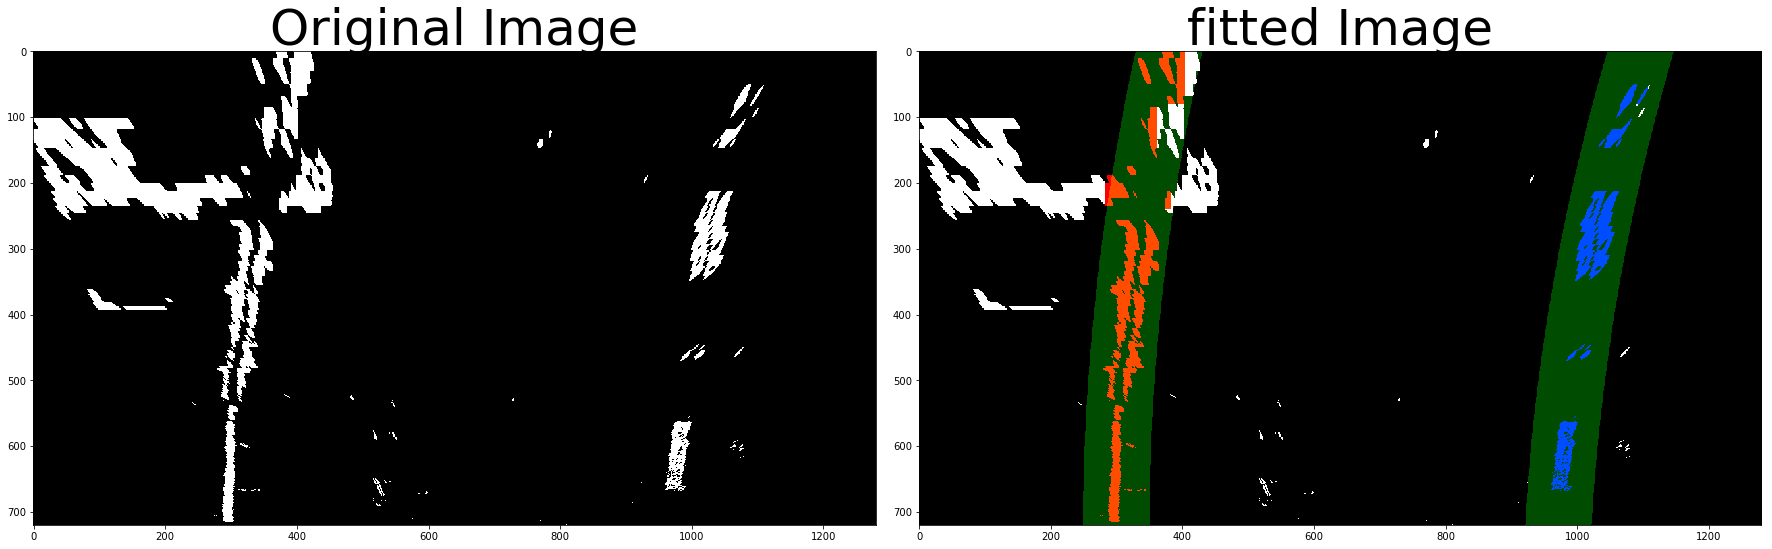

In [48]:
flag_exist_fit_data = False
left_fit = None
right_fit = None

def  fit_lane(binary_warped):
    '''
    find lane line polynomial from binary image
    '''
    
    global flag_exist_fit_data , left_fit, right_fit
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])    
    
#     print(flag_exist_fit_data)
    if flag_exist_fit_data == False :
        left_lane_inds, right_lane_inds = brutal_search(binary_warped)
        flag_exist_fit_data = True
#         print('brutal search , flag ={}'.format(flag_exist_fit_data))
    else :
        left_lane_inds, right_lane_inds = fast_search(binary_warped,left_fit,right_fit)
        flag_exist_fit_data = True    
#         print('fast search , flag ={}'.format(flag_exist_fit_data))
        
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

#     ## left , right line should be parallel.
#     ## using this fact , copy left line -> right line and vice versa.
#     ## by doing this, you can average the information of left&right line
#     ## robut in normal case and extremely effective when a line don't have enough data to fit in.
#     rightx_2_leftx =  rightx - distance_left_right
#     leftx_2_rightx =  leftx  + distance_left_right
#     leftx = np.concatenate((leftx , rightx_2_leftx))
#     rightx = np.concatenate((rightx , leftx_2_rightx))

#     righty_2_lefty = righty
#     lefty_2_righty = lefty
#     lefty = np.concatenate((lefty , righty_2_lefty))
#     righty = np.concatenate((righty , lefty_2_righty))


    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    
    ## draw result image
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)

    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))

    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return left_fit,right_fit,result_img

left_fit,right_fit,result_img = fit_lane(binary_warped)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(binary_warped,cmap='gray')
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(result_img)
ax2.set_title('fitted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [49]:
def get_road_data(left_fit,right_fit,binary_warped) :
    '''
    Calculate curvature and distance from lane center
    '''
      
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Fit new polynomials to x,y in world space
    leftx = left_fitx
    rightx = right_fitx
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    

    # distance from the lane center
    lane_center = (right_fitx[719] + left_fitx[719])/2
    center_offset_pixels = abs(imshape[1]/2 - lane_center)
    distance_from_center = xm_per_pix*center_offset_pixels    
    
    return right_curverad , distance_from_center

curvature , distance_from_center = get_road_data(left_fit,right_fit,binary_warped)

# Now our radius of curvature is in meters
print('curvature = {}'.format(curvature) + 'm')
print('Distance from the lane center = {}'.format(distance_from_center) + 'm')

curvature = 1007.5464580820328m
Distance from the lane center = 0.02538846583216553m


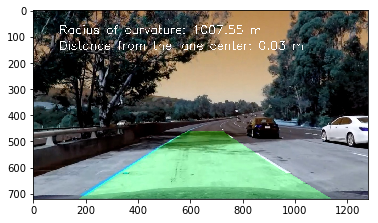

In [50]:
def overlay_result(undist_img , result_img, left_fit, right_fit, curvature_text_on_img, distance_from_center_text_on_imag) :
    '''
    Overlay result to the original image
    '''

    # Create an image to draw the lines on
    warp = result_img
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Generate x and y values for plotting
    ploty = np.linspace(0, result_img.shape[0]-1, result_img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = perspective_transform(color_warp,warp_unwarp = 'unwarp')

    # Combine the result with the original image
    overlayed_result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
    cv2.putText(overlayed_result,curvature_text_on_img , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    cv2.putText(overlayed_result, distance_from_center_text_on_imag, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)

    return overlayed_result


curvature_text_on_img = "Radius of curvature: %.2f m" % curvature
distance_from_center_text_on_imag = "Distance from the lane center: %.2f m" % distance_from_center
overlayed_result = overlay_result(undist_img , result_img, left_fit, right_fit, curvature_text_on_img, distance_from_center_text_on_imag)
plt.imshow(overlayed_result)

## Pipleline Implementation
---
_Final pipeline that detects lane area, calculating curvature and offset from lane center from pure image._

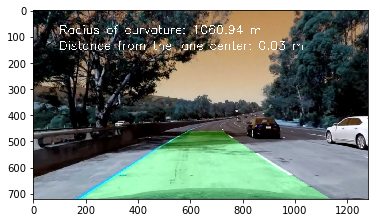

In [51]:
flag_exist_fit_data = False
left_fit = None
right_fit = None

def pipeline_lane_finding(image):
    
    global flag_exist_fit_data, left_fit, right_fit
       
    ## undistort image
    undist_img = undistort(image)
    
    ## get binary lane detected image
    binary_lane =  find_lane_binary(undist_img)
    
    ## perspective transform on top view "bird's eye view"
    binary_warped = perspective_transform(binary_lane , warp_unwarp ='warp')
    
    ## get fitted polynomial of lane line and an image polyline is drawn. 
    left_fit,right_fit,result_img = fit_lane(binary_warped)
    
    ## Get curvature and center offset 
    curvature , distance_from_center = get_road_data(left_fit,right_fit,binary_warped)
    curvature_text_on_img = "Radius of curvature: %.2f m" % curvature
    distance_from_center_text_on_imag = "Distance from the lane center: %.2f m" % distance_from_center        
    
    ## overlay all onto original image
    overlayed_result = overlay_result(undist_img , result_img, left_fit, right_fit, curvature_text_on_img, distance_from_center_text_on_imag)
    
    return overlayed_result
    
## test code
overlayed_result = pipeline_lane_finding(undist_img)
plt.imshow(overlayed_result)

## Test on Videos

In [25]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### Project Video

In [52]:
output1 = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline_lane_finding) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output1, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output1))

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [04:13<00:00,  4.96it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 4min 15s


In [27]:
# output2 = 'challenge_video_output.mp4'
# clip1 = VideoFileClip("challenge_video.mp4")
# white_clip = clip1.fl_image(pipeline_lane_finding) #NOTE: this function expects color images!!
# %time white_clip.write_videofile(output2, audio=False)

# HTML("""
# <video width="960" height="540" controls>
#   <source src="{0}">
# </video>
# """.format(output2))